In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.collision_operator_HG_3D import CollisionOperatorHG3D



In [2]:

def setup_lattice_test(n_x, n_y):
    # Define parameters
    L = 7.0  # Length of the 1D domain

    dx = L / n_x  # Spatial grid size
    dy = L / n_y  # Spatial grid size

    source_strength = 1.0
    source = np.zeros((n_x, n_y))  # Source term

    sigma_a = np.zeros((n_x, n_y))
    sigma_s = np.ones((n_x, n_y))

    lbounds = [1, 2, 3, 4, 5]
    ubounds = [2, 3, 4, 5, 6]

    for i in range(n_x):
        for j in range(n_y):
            pos = [i * dx, j * dy]
            for k in range(len(lbounds)):
                for l in range(len(lbounds)):
                    if lbounds[k] <= pos[0] <= ubounds[k] and lbounds[l] <= pos[1] <= ubounds[l]:
                        if (l + k) % 2 == 1 or (k == 2 and l == 2) or (k == 2 and l == 4):
                            continue
                        else:
                            sigma_a[i, j] = 10.
                            sigma_s[i, j] = 0.0

            if 3 <= pos[0] <= 4 and 3 <= pos[1] <= 4:
                source[i, j] = source_strength
    return sigma_a, sigma_s, source, dx, dy, L



In [3]:
def get_upwind_flux(i, j, omega_q, f_q, dx, dy):
    flux = 0.0
    flux += -dy * omega_q[0] * f_q[i, j] if -1 * omega_q[0] >= 0 else -dy * omega_q[0] * f_q[i - 1, j]  # left nbr
    flux += dy * omega_q[0] * f_q[i, j] if omega_q[0] >= 0 else dy * omega_q[0] * f_q[i + 1, j]  # right nbr
    flux += -dx * omega_q[1] * f_q[i, j] if -1 * omega_q[1] >= 0 else -dx * omega_q[1] * f_q[i, j - 1]  # down nbr
    flux += dx * omega_q[1] * f_q[i, j] if omega_q[1] >= 0 else dx * omega_q[1] * f_q[i, j + 1]  # up nbr

    return flux


In [44]:

def run_simulation(f_init, n_x, n_y, n_q, n_t, dt, dx, dy, sigma_s, sigma_a, source, omega, Q: CollisionOperatorHG3D):
    f_kin = np.copy(f_init)
    fluxes = np.zeros(shape=(n_q[0], n_q[1], n_x, n_y))
    area = (dy * dx) / (dx + dy)
    # Perform time-stepping
    for k in tqdm(range(n_t)):
        for i in range(1, n_x - 1):
            for j in range(1, n_y - 1):
                for q1 in range(n_q[0]):
                    for q2 in range(n_q[1]):
                        # fluxes in 2D
                        fluxes[q1, q2, i, j] = get_upwind_flux(i, j, omega[:, q1, q2], f_kin[q1, q2, :, :], dx, dy)

        for i in range(1, n_x - 1):
            for j in range(1, n_y - 1):
                collision = Q.evaluate_Q(f_kin[:, :, i, j])  # dependent on omega(my phi)=[v_x,v_y]

                for q1 in range(n_q[0]):
                    for q2 in range(n_q[1]):
                        # Update angular flux using finite difference method
                        f_kin[q1, q2, i, j] = (f_kin[q1, q2, i, j]
                                               - dt / area * fluxes[q1, q2, i, j]
                                               + dt * sigma_s[i, j] * collision[q1, q2]
                                               + dt * source[i, j]
                                               - dt * sigma_a[i, j] * f_kin[q1, q2, i, j])
    return f_kin



In [86]:




n_x = 40
n_y = 40
sigma_a, sigma_s, source, dx, dy, length = setup_lattice_test(n_x=n_x, n_y=n_y)
# Angular discretization (Discrete Ordinates)
q_order = 4  # quadrature order
Q = CollisionOperatorHG3D(integrator_order=q_order, anisotropy_param=0.0)  # EXCHANGE BY nueral Network!
omega = Q.get_quad_pts()
w_q = Q.get_quad_weights()

n_q = Q.n_q
# Initialize angular flux and boundary conditions
f_init = np.zeros((n_q[0], n_q[1], n_x, n_y))  # tensorized in (my,phi,x,y)
# f_init[:, :, 5:10, 5:10] = 1.0
# Define the time step and number of time steps
dt = 0.4 * dx * dy / (dx + dy)  # obeys cfl
n_t = int(2.6/dt)


# Plot the angular flux for one angle (e.g., the first angle)






In [87]:
print('Start simulation')
f_tN = run_simulation(f_init, n_x, n_y, n_q, n_t, dt, dx, dy, sigma_s, sigma_a, source, omega, Q)
print('Finished simulation at t_n = ' + str(dt * n_t) + ' sec.')

f_res_tn = np.einsum('ij,ijkl', w_q, f_tN) / (4 * np.pi)
f_res_t0 = np.einsum('ij,ijkl', w_q, f_init) / (4 * np.pi)

Start simulation


100%|██████████████████████████████████████████████████████████████████| 74/74 [03:03<00:00,  2.47s/it]

Finished simulation at t_n = 2.59 sec.


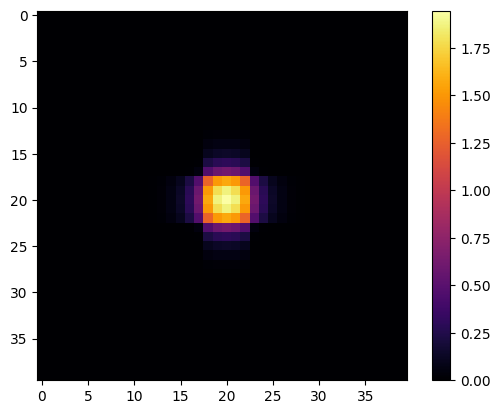

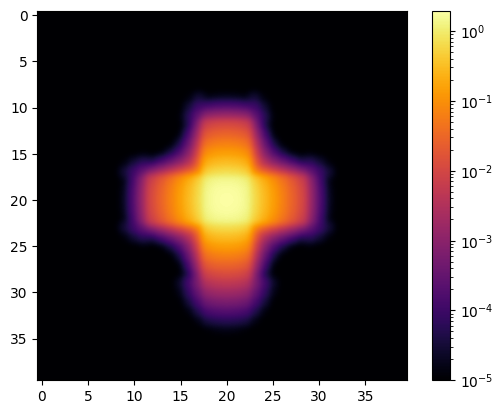

In [88]:
plt.imshow(f_res_tn.T, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.savefig('lattice_2d_tn.png')
plt.savefig('lattice_2d_tn.pdf')
plt.show()

from matplotlib.colors import LogNorm

f_res_tn = np.maximum(f_res_tn, 1e-5)

plt.imshow(f_res_tn.T, cmap='inferno', interpolation='gaussian', norm=LogNorm())
plt.colorbar()
plt.savefig('lattice_2d_tn_log.png')
plt.savefig('lattice_2d_tn_log.pdf')
plt.show()

In [89]:
gparams = {
     'name': 'wo_bias',
     'seed': 0,
     'use_squeue': False,
     'dimension': 3,
     'data_file': 'legendre',
     'integration_order': 100,
     'model': 'deeponet',
     'branch_hidden': [32, 100, 100, 8],
     'trunk_hidden': [3, 100, 100, 8],
     'act': 'tanh',
     'd_out': 1,
     'use_bias': 'no',
     'use_gram': False,
     'batch_size': 0,
     'epochs': 100000,
     'lr': 0.001,
     'lambda': 0.0
}
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3D/entropy/wo_bias',
    #'3D/entropy/w_bias',
    '3D/entropy/soft_lamb',
    #'3D/entropy/hard_gram',
    #'3D/entropy/hard_special',
]



In [90]:
w_q = Q.get_quad_weights()
v_q = Q.get_quad_pts()
print(v_q.reshape(3,v_q.shape[1]*v_q.shape[2],1).shape)
print(w_q.reshape(v_q.shape[1]*v_q.shape[2],1).shape)

(3, 32, 1)
(32, 1)


In [91]:
## quad pts and weights
import torch
integration_order=gparams['integration_order']
if gparams['dimension']==3:
    w_q = Q.get_quad_weights()
    v_q = Q.get_quad_pts()
    grid = torch.FloatTensor(v_q.reshape(3,v_q.shape[1]*v_q.shape[2])).T.cpu()
    quad_w = torch.FloatTensor(w_q.reshape(v_q.shape[1]*v_q.shape[2],1)).cpu()
    size_domain=2

In [92]:
### Model
from model.deeponet import *

models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+list_filename[idx_model]+'/args.bin', map_location=torch.device('cpu'))
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## We want a cpu model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cpu()
        save_model=torch.load('results/'+model+'/final.bin', map_location=torch.device('cpu'))
        DeepONet.load_state_dict(save_model['state_dict'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

In [93]:

def run_neural_simulation(f_init, n_x, n_y, n_q, n_t, dt, dx, dy, sigma_s, sigma_a, source, omega,
                          Q_theta):
    f_kin = np.copy(f_init)
    fluxes = np.zeros(shape=(n_q[0], n_q[1], n_x, n_y))
    area = (dy * dx) / (dx + dy)
    # Perform time-stepping
    for k in tqdm(range(n_t)):
        for i in range(1, n_x - 1):
            for j in range(1, n_y - 1):
                for q1 in range(n_q[0]):
                    for q2 in range(n_q[1]):
                        # fluxes in 2D
                        fluxes[q1, q2, i, j] = get_upwind_flux(i, j, omega[:, q1, q2], f_kin[q1, q2, :, :], dx, dy)

        for i in range(1, n_x - 1):
            for j in range(1, n_y - 1):
                
                mass = np.einsum('ij,ij', w_q, f_kin[:,:, i, j]) 
                if mass==0:
                    # _f = torch.FloatTensor(f_kin[:, i].reshape(1, 1,-1))
                    # collision = model(_f, grid).squeeze().detach().numpy()
                    collision=np.zeros(f_kin[:,:, i, j].shape)
                else:
                    f_normalized = f_kin[:,:, i, j] / mass * 3.5449
                    _f = torch.FloatTensor(f_normalized.reshape(1, 1, n_q[0]* n_q[1]))
                    collision = Q_theta(_f, grid).squeeze().detach().numpy() * mass / 3.5449
                    collision = collision.reshape(n_q[0], n_q[1])

                for q1 in range(n_q[0]):
                    for q2 in range(n_q[1]):
                        # Update angular flux using finite difference method
                        f_kin[q1, q2, i, j] = (f_kin[q1, q2, i, j]
                                               - dt / area * fluxes[q1, q2, i, j]
                                               + dt * sigma_s[i, j] * collision[q1, q2]
                                               + dt * source[i, j]
                                               - dt * sigma_a[i, j] * f_kin[q1, q2, i, j])
    return f_kin

In [94]:
print('Start simulation')
f_tN0 = run_neural_simulation(f_init, n_x, n_y, n_q, n_t, dt, dx, dy, sigma_s, sigma_a, source, omega, models[0])
print('Finished simulation at t_n = ' + str(dt * n_t) + ' sec.')

f_res_tn0 = np.einsum('ij,ijkl', w_q, f_tN0) / (4 * np.pi)
f_res_t0 = np.einsum('ij,ijkl', w_q, f_init) / (4 * np.pi)

Start simulation


100%|██████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.83it/s]

Finished simulation at t_n = 2.59 sec.


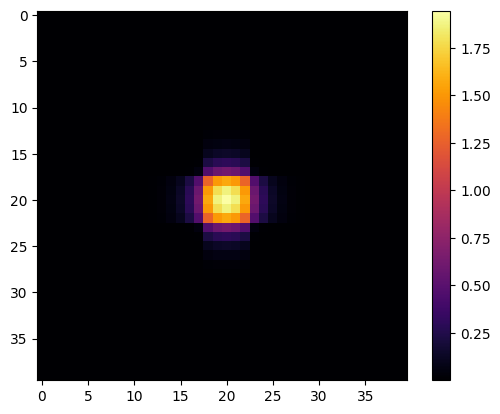

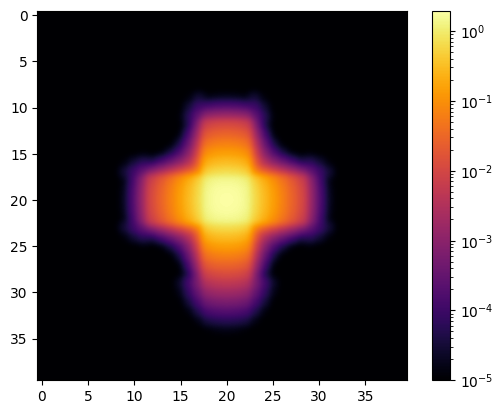

In [95]:
plt.imshow(f_res_tn.T, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.savefig('lattice_2d_tn.png')
plt.savefig('lattice_2d_tn.pdf')
plt.show()

from matplotlib.colors import LogNorm

f_res_tn = np.maximum(f_res_tn, 1e-5)

plt.imshow(f_res_tn.T, cmap='inferno', interpolation='gaussian', norm=LogNorm())
plt.colorbar()
plt.savefig('lattice_2d_tn_log.png')
plt.savefig('lattice_2d_tn_log.pdf')
plt.show()

In [96]:
print('Start simulation')
f_tN0 = run_neural_simulation(f_init, n_x, n_y, n_q, n_t, dt, dx, dy, sigma_s, sigma_a, source, omega, models[1])
print('Finished simulation at t_n = ' + str(dt * n_t) + ' sec.')

f_res_tn0 = np.einsum('ij,ijkl', w_q, f_tN0) / (4 * np.pi)
f_res_t0 = np.einsum('ij,ijkl', w_q, f_init) / (4 * np.pi)

Start simulation


100%|██████████████████████████████████████████████████████████████████| 74/74 [00:20<00:00,  3.57it/s]

Finished simulation at t_n = 2.59 sec.


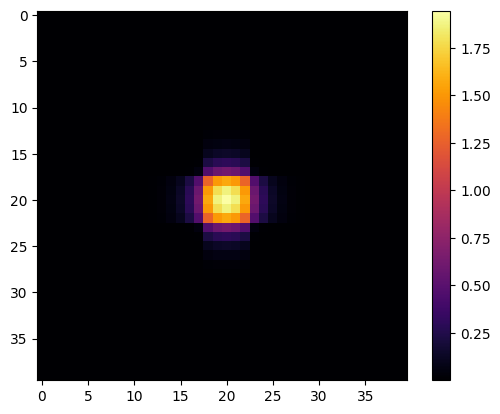

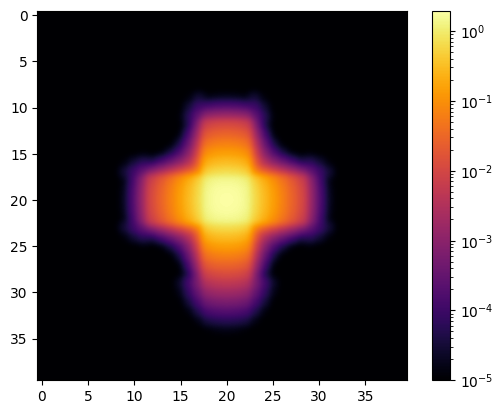

In [97]:
plt.imshow(f_res_tn.T, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.savefig('lattice_2d_tn.png')
plt.savefig('lattice_2d_tn.pdf')
plt.show()

from matplotlib.colors import LogNorm

f_res_tn = np.maximum(f_res_tn, 1e-5)

plt.imshow(f_res_tn.T, cmap='inferno', interpolation='gaussian', norm=LogNorm())
plt.colorbar()
plt.savefig('lattice_2d_tn_log.png')
plt.savefig('lattice_2d_tn_log.pdf')
plt.show()